# Determining the lightcurves of stellar clusters

The purpose of this notebook is to download large (1 deg by 1 deg) FFIs of several clusters, create a mask isolating the sky pixels, and use that mask to subtract the background from the lightcurves. Each of these three steps will have their own parts. The clusters we will investigate are:

- M34
- M7
- NGC 752
- IC 2391
- NGC 6231
- Lambda Orionis (might be on the edge of the TESS field)
- NGC 3532
- Collinder 140

and we will also investigate these globular clusters:

- Omega Cen
- 47 Tuc
- M4
- NGC 6752.

Due to the size of these FFIs, my laptop tends to run out of memory if more than two or three clusters are run at a time. To do clusters than this at a time, the order of the code has to be rearranged so that all the processing is done on one cluster at a time, and the TPF and lightcurve are deleted before moving onto the next cluster.

## To do:

- Find a good distribution to fit the histograms
- Try a custom background subtraction algorithm?

In [1]:
import lightkurve as lk
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

CLUSTERS = ["NGC 752", "NGC 6231", "NGC 3532"]
COORDS = {"M34":(40.53083, 42.74615), "M7":(268.46325, -34.79283), "NGC 752":(29.421, 37.785), "IC 2391": (130.133, -53.033), 
          "NGC 6231":(253.53546, -41.82667), "Lambda Orionis":(83.78449002, 9.93415587), "NGC 3532":(166.44923, -58.7705),
          "Collinder 140":("111.113", "-31.85"),
          "Omega Cen": (201.69121, -47.47686), "47 Tuc": (6.022329, -72.081444), "M4": (245.89675, -26.52575), 
          "NGC 6752": (287.71575, -59.98185)}
LIGHTKURVE_CACHE = "/home/jtdinsmo/.lightkurve-cache/tesscut/"

## 1. Downloading the FFIs

We will start by downloading the FFIs of these clusters with `lightkurve`. However, if the file has already been downloaded, we will load it from the disk instead.

In [2]:
tpfs = [0]*len(CLUSTERS)

for i in range(len(CLUSTERS)):
    foundLocal = False
    for file in os.listdir(LIGHTKURVE_CACHE):
        if file.endswith("180x180_astrocut.fits"): # Confirm size
            if COORDS[CLUSTERS[i]][0] == float(file.split("_")[-4]): # Confirm RA
                if COORDS[CLUSTERS[i]][1] == float(file.split("_")[-3]): # Confirm dec
                    tpfs[i] = lk.TessTargetPixelFile(LIGHTKURVE_CACHE + file)
                    foundLocal = True
                    break
    if not foundLocal:
        search = lk.search_tesscut(CLUSTERS[i])
        char = ""
        if len(search) != 1: char = "s"
        print("{0} has {1} result{2}.".format(CLUSTERS[i], len(search), char))
        tpfs[i] = search[0].download(cutout_size=180)

Now we will display the tpfs. We pick a frame in the middle of the exposure to avoid edge effects. Some of the clusters appear on the edge of a sector, which causes them to be partially cut off.

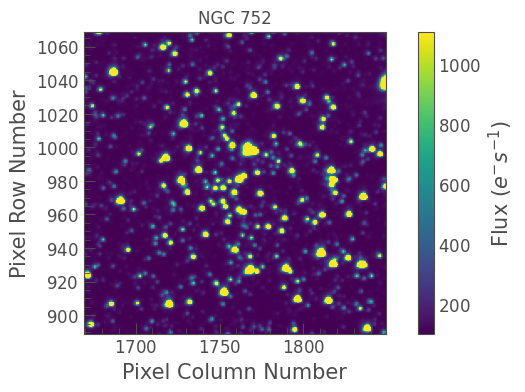

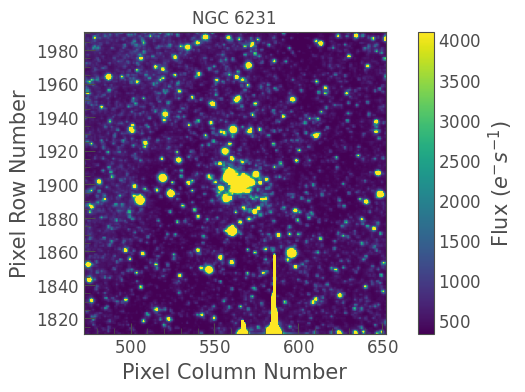

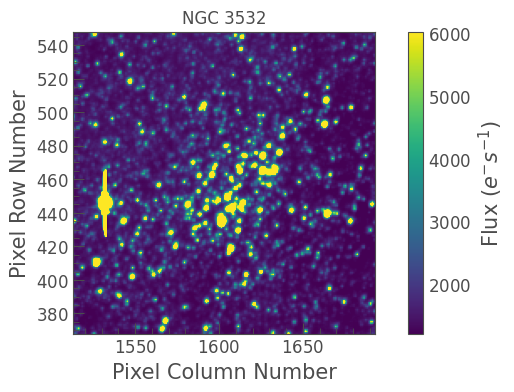

In [3]:
for i in range(len(CLUSTERS)):
    p = tpfs[i].plot(frame=tpfs[i].shape[0] // 2)
    p.set_title(CLUSTERS[i])

## 2. Creating the sky mask

In this part, we will create a mask that isolates the sky pixels from the others for use in background subtraction.

To determine sky pixels, we will make a histogram of the brightness of the pixels in the particular cadence shown above. We expect as many as four peaks; from lowest to highest brightness they represent

1. Black pixels because they are on the edge of the sector
2. Sky pixels
3. Star pixels
4. Saturated pixels

In [16]:
import math

X_SCALE = 25
SHAPES = {"M34":(40.53083, 42.74615), "M7":(268.46325, -34.79283), "NGC 752":4.8, "IC 2391": (130.133, -53.033), 
          "NGC 6231":50, "Lambda Orionis":(83.78449002, 9.93415587), "NGC 3532":120,
          "Collinder 140":("111.113", "-31.85"),
          "Omega Cen": (201.69121, -47.47686), "47 Tuc": (6.022329, -72.081444), "M4": (245.89675, -26.52575), 
          "NGC 6752": (287.71575, -59.98185)}

def distribution(k, binwidth, mean):# Poisson
    # Discrete distribution
    '''k = int(k / X_SCALE)
    f = 180*180 * binwidth * math.exp(-mean)
    for i in range(1, k+1):
        f *= mean / i'''
    # Continuous distribution
    k = k / X_SCALE
    f = 180 * 180 * binwidth * math.exp(-mean) * mean**k / math.gamma(k+1) / 10
    
    return f

/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars


OverflowError: math range error

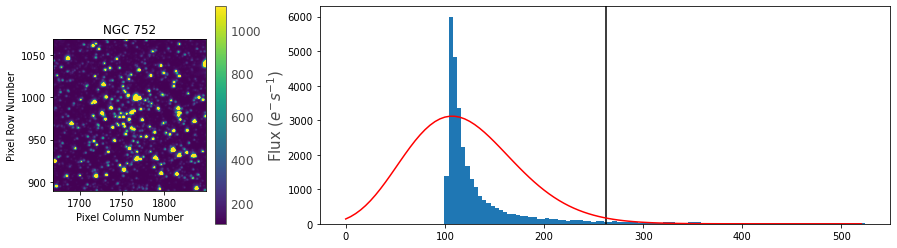

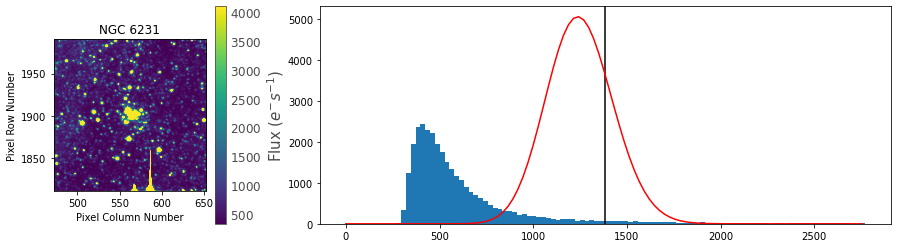

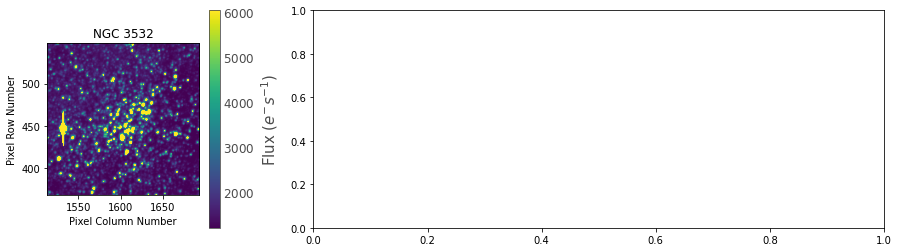

In [17]:
for i in range(len(CLUSTERS)):
    frame = tpfs[i].shape[0]//2
    brightnessData = tpfs[i][frame].flux.reshape(180*180)
    mean = np.mean(brightnessData)
    lower_limit = 0
    upper_limit = int(2 * mean)
    brightnessData = brightnessData[np.where((brightnessData >= lower_limit) & (brightnessData <= upper_limit))]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
    tpfs[i].plot(ax=ax1, frame=tpfs[i].shape[0] // 2)
    ax1.set_title(CLUSTERS[i])
    
    x = np.arange(start=0, stop=upper_limit, step=int(upper_limit/100))
    y = np.array([distribution(k, (upper_limit - lower_limit) / 100, SHAPES[CLUSTERS[i]]) for k in x])
    
    ax2.hist(brightnessData, bins=100)
    ax2.axvline(mean, color='k')
    ax2.plot(x, y, color='r', zorder=2)

Now that we have an idea of what the data looks like, we can actually create the sky mask. We will need to pick a range of fluxes which define "sky pixels."

The lower limit is easy to pick; we want to include the darkest parts of the image in our sky mask, but we don't want to include the blank CCDs present at the edge of sectors. So we set the lower limit to be a very low flux &mdash; say 5 &mdash; which excludes these pixels.

The upper limit is harder to pick. Some possible methods are listed below, together with their drawbacks.
1. **The $n$th percentile of flux**. How do we choose $n$? Manually across the sectors? Also, if $n$ is constant across all the clusters, we are assuming that the "true" ratio of stars to sky is constant, which is probably not true.
1. **The most common flux**. The mode is not always a sharp peak in these histograms. How do we know it's physically meaningful as an upper limit to sky pixel flux?
1. **Fit the histograms to some distribution and use a statistical threshold**. This is probably the most physical of the options, but I have to pick a distribution and a statistic. Attempted distributions are listed below.
    - Poisson distribution: too steep and too easily turned into a normal distribution. Even if you right-shift it so that you can use lower shape parameters, it doesn't fit.

These possibilities are encoded in the function below.

In [ ]:
UPPER_LIMIT_METHOD = 1

# Global values for method 1
PERCENTILE = 85

# Global values for method 2
BINS = 300

# Global values for method 3


def getUpperLimit(dataDistribution):
    if UPPER_LIMIT_METHOD == 1:
        return np.nanpercentile(dataDistribution, PERCENTILE)
    
    elif UPPER_LIMIT_METHOD == 2:
        hist = np.histogram(dataDistribution, bins=BINS, range=(0, 3000))# Bin the data
        return hist[1][np.argmax(hist[0])]# Return the flux corresponding to the most populated bin
    
    elif UPPER_LIMIT_METHOD == 3:
        pass
        
    else:
        return 150

Now that we have defined the upper- and lower-limits to sky pixel flux, we can create a mask that contains all the sky pixels. We will also create a mask that covers the stars; it contains all the pixels with flux higher than the upper limit for sky pixels.

In [ ]:
skyMasks = [0] * len(CLUSTERS)
starMasks = [0] * len(CLUSTERS)

for i in range(len(CLUSTERS)):
    frame = tpfs[i].shape[0]//2
    lowerLimit = 5
    upperLimit = getUpperLimit(tpfs[i][frame].flux.reshape(180*180))
    print("{0}: [{1}, {2}]".format(CLUSTERS[i], lowerLimit, upperLimit))
    skyMasks[i] = ((tpfs[i][frame].flux >= lowerLimit) & # Exclude edge pixels
        (tpfs[i][frame].flux <= upperLimit)).reshape(180, 180)
    starMasks[i] = ((tpfs[i][frame].flux > upperLimit)).reshape(180, 180)

Finally, we display the mask by displaying all the sky pixels and setting the non-sky pixels equal to zero.

In [ ]:
for i in range(len(CLUSTERS)):
    frame = tpfs[i].shape[0]//2
    skyFlux = np.ma.array(tpfs[i][frame].flux, mask=~skyMasks[i]).reshape(180, 180).filled(fill_value=0)
    starFlux = np.ma.array(tpfs[i][frame].flux, mask=~starMasks[i]).reshape(180, 180).filled(fill_value=0)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4))
    ax1.imshow(skyFlux, vmin=0, vmax=np.nanpercentile(tpfs[i][frame].flux, 95))
    ax1.set_title(CLUSTERS[i] + " sky mask values")
    ax2.imshow(starFlux, vmin=0, vmax=np.nanpercentile(tpfs[i][frame].flux, 95))
    ax2.set_title(CLUSTERS[i] + " star mask values")

## 3. Creating the lightcurves

In this section, we will apply the mask defined above and create a lightcurve based on it using the standard `lightkurve` method. First, we create the uncorrected lightcurves:

In [ ]:
lightcurves = [tpfs[i].to_lightcurve(aperture_mask=starMasks[i]) for i in range(len(CLUSTERS))];

Then, we subtract the background radiation and create a new lightcurve.

In [ ]:
NUMBER_PCA_COMPONENTS = 10

regressors = [tpfs[i].flux[:, skyMasks[i]] for i in range(len(CLUSTERS))]# The regressor is the inverse of the aperture

dms = [lk.DesignMatrix(r, name='regressors').pca(NUMBER_PCA_COMPONENTS).append_constant() for r in regressors]
correctors = [lk.RegressionCorrector(lc) for lc in lightcurves]
correctedLCs = [correctors[i].correct(dms[i]) for i in range(len(CLUSTERS))]

Finally, we draw the new lightkurve and compare it to the un-corrected one.

In [ ]:
for i in range(len(CLUSTERS)):
    plot = lightcurves[i].plot(marker='.', ls='none', color='r');# This is where you would flatten the curves
    plot2 = correctedLCs[i].plot(marker='.', ls='none', color='b');# This is where you would flatten the curves
    plot.set_title("TESS 2-min lightcurve for {0}: method {1}.".format(CLUSTERS[i], UPPER_LIMIT_METHOD));
    plot2.set_title("TESS 2-min lightcurve for {0}: method {1}, corrected.".format(CLUSTERS[i], UPPER_LIMIT_METHOD));

Conclusions: method 1 seems better than method 2. I have not yet found a distribution to match the data, but I have hopes that this will be the best method.

In general, the more background pixels, the better the image is what it seems, which I also saw in some `eleanor` experiments. Except 95\% of the pixels is too many. For the last image (with more stars, 75\% may be better than 80\%).

Should I have such great confidence in the `lightkurve` method of background subtraction? I could also just manually subtract the mean brightness of the backround from the mean brightness of the frame for all the frames and plot that.